In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from data.datasets import ADNIDataset

#### Load experiment

In [10]:
# Experiment folder
exp_dir = './experiments/mynet2_good/'

In [13]:
# Load config
cfg = OmegaConf.load(exp_dir + '/config.yaml')

In [17]:
# Load test dataset
test_dataset = ADNIDataset(cfg.data.test_csv)

In [6]:
# Load model
model = torch.load('./experiments/mynet2_good/fold_1/best_model.pth', map_location=torch.device('cpu'), weights_only=False)
model

MyNet2(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock): ResidualBlock3D(
    (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv3d(32, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn4): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cbam_

#### Register hooks to store layer activations

In [26]:
# 1. Dictionary to store activations
activations = {}

# 2. Hook function
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu()
    return hook

# 3. Register hooks to all layers
for name, layer in model.named_modules():
    # Only register to layers with parameters (skip containers like nn.Sequential)
    if len(list(layer.children())) == 0:
        layer.register_forward_hook(get_activation(name))

#### View activations

In [92]:
sample_index = 3
img,lbl = test_dataset[sample_index]

In [93]:
model.eval()
with torch.no_grad():
    output = model(img.unsqueeze(0))  # or your input shape

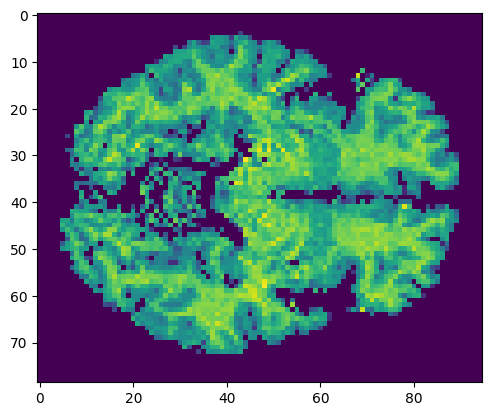

In [94]:
#Show input
plt.imshow(img[0,:,:,30])

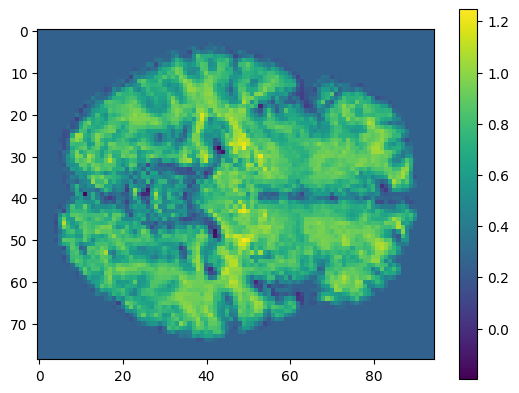

In [95]:
# Conv1 (1, 16, 79, 95, 79)
plt.imshow( activations['conv1'][0,15,:,:,30])
plt.colorbar()

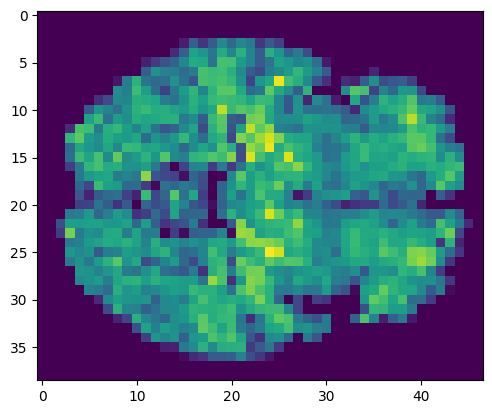

In [96]:
# Pool 1 (1, 16, 39, 47, 39)
plt.imshow(activations['pool1'][0,15,:,:,15])

In [97]:
for name, val in activations.items():
    print(name)

conv1
bn1
pool1
resblock.shortcut
resblock.conv1
resblock.bn1
resblock.conv2
resblock.bn2
pool2
conv4
bn4
cbam_final.ca.mlp.0
cbam_final.ca.mlp.1
cbam_final.ca.mlp.2
cbam_final.sa.conv
gap
fc


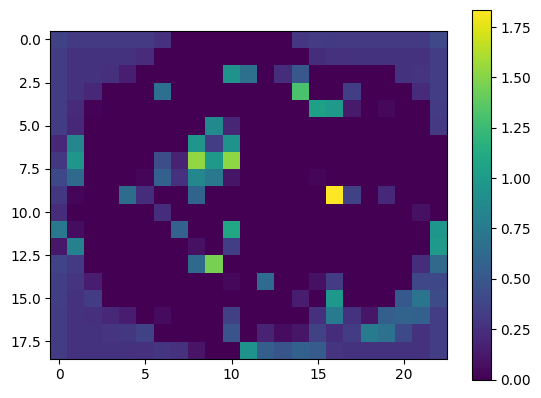

In [105]:
# Pool 2 (1, 32, 19, 23, 19)
plt.imshow(activations['pool2'][0,0,:,:,8])
plt.colorbar()

In [102]:
activations['gap']

tensor([[[[[0.1225]]],


         [[[0.0667]]],


         [[[1.5173]]],


         [[[0.5741]]],


         [[[0.0853]]],


         [[[1.4346]]],


         [[[0.5559]]],


         [[[0.8013]]]]])

In [107]:
model.__module__

'models.model_mynet2'

In [108]:
import inspect

In [111]:
inspect.getfile(model.__class__)

'/project/aereditato/cestari/adni-mri-classification/models/model_mynet2.py'